# Wikipedia Web Traffic Data

The dataset is available [on Kaggle](https://www.kaggle.com/c/web-traffic-time-series-forecasting/data)

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

## Imports and reading data

We read the data and fill any non-existing values with 0, representing 0 views for the specific page on that day.

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import re
from statsmodels.tsa.arima_model import ARIMA
from dtaidistance import dtw
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import mean_squared_log_error
import holidays
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

from lightgbm import LGBMRegressor

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

import datetime

import time
import tsfresh

In [3]:
original_dataset = pd.read_csv("data/train_2.csv")
original_dataset.info()
original_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 804 entries, Page to 2017-09-10
dtypes: float64(803), object(1)
memory usage: 889.8+ MB


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


## Removing all rows with NaN

In [4]:
original_dataset.dropna(axis='index',inplace=True)
original_dataset.reset_index(inplace=True,drop=True)
original_dataset.info()
original_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115084 entries, 0 to 115083
Columns: 804 entries, Page to 2017-09-10
dtypes: float64(803), object(1)
memory usage: 705.9+ MB


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,13.0,13.0,45.0,4.0,13.0,20.0,18.0,17.0,14.0,11.0


## Visualising some series

In [5]:
def plot_series(series, title, new_plot = True, plot_show = True, label = None, color='blue'):
    if new_plot:
        plt.figure(figsize=(20,10))
    days = range(series.shape[0])
    plt.plot(days,series,label=label, color=color)
    plt.title(title)
    plt.xlabel("Days")
    plt.ylabel("Views")
    if plot_show:
        plt.legend()
        plt.show()

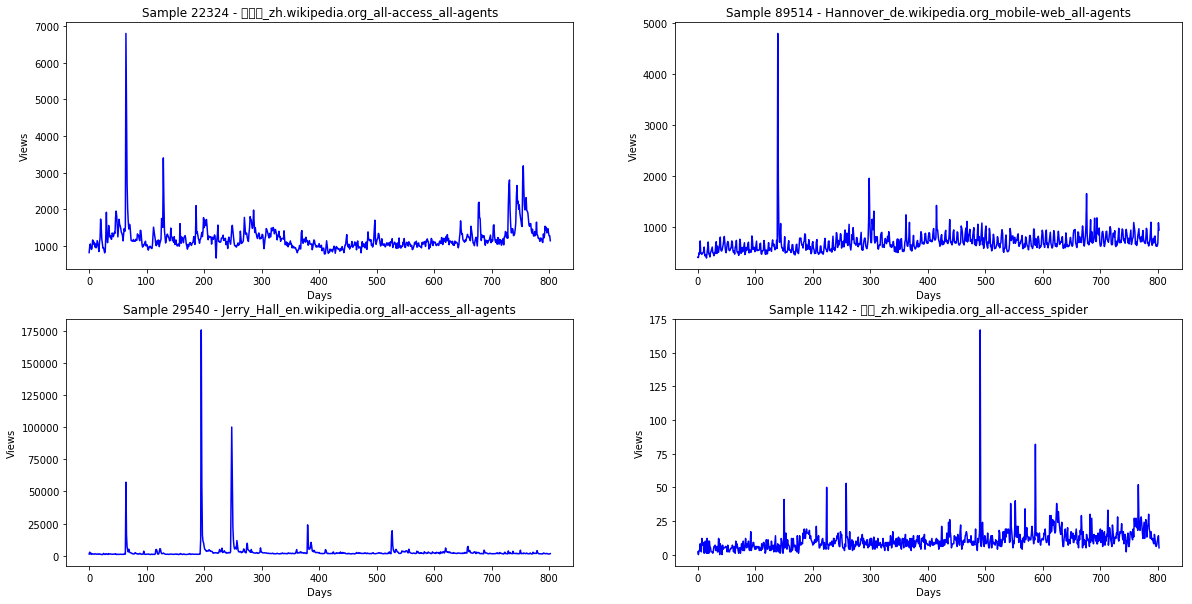

In [6]:
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    sample = random.randint(0,original_dataset.shape[0])
    data = original_dataset.iloc[sample,1:]
    plot_series(data,f"Sample {sample} - {original_dataset.iloc[sample,0]}",new_plot=False,plot_show=False)
plt.show()

## Extracting metadata

Here, we take the compound page name and extract the name of the article, the language, the type of access and the agent for each page.

In [7]:
def extract_meta(page):
    parts = page.split("_")
    [project,access,agent] = parts[-3:]
    name = " ".join(parts[0:-3])
    match_lang = re.search("([a-z][a-z])\.wikipedia\.org",project)
    lang = match_lang.group(1) if match_lang else 'na'
    return [name,lang,access,agent]

In [8]:
meta_dataset = original_dataset.copy()
meta_dataset['name'],  meta_dataset['lang'], meta_dataset['access'], meta_dataset['agent'] = zip(*meta_dataset['Page'].apply(extract_meta))
meta_dataset = meta_dataset[['name', 'lang', 'access', 'agent'] + [c for c in meta_dataset if c not in ['Page', 'name', 'lang', 'access', 'agent']]]

In [9]:
meta_dataset.head()

,name,lang,access,agent,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1,zh,all-access,spider,18.0,11.0,5.0,13.0,14.0,9.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM,zh,all-access,spider,11.0,14.0,15.0,18.0,11.0,13.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C,zh,all-access,spider,1.0,0.0,1.0,1.0,0.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute,zh,all-access,spider,35.0,13.0,10.0,94.0,4.0,26.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,5566,zh,all-access,spider,12.0,7.0,4.0,5.0,20.0,8.0,...,13.0,13.0,45.0,4.0,13.0,20.0,18.0,17.0,14.0,11.0


In [10]:
ordinal_encoder = OrdinalEncoder()
meta_dataset.iloc[:,:4] = ordinal_encoder.fit_transform(meta_dataset.iloc[:,:4])

In [11]:
meta_dataset.head()

,name,lang,access,agent,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,588.0,7.0,0.0,1.0,18.0,11.0,5.0,13.0,14.0,9.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,589.0,7.0,0.0,1.0,11.0,14.0,15.0,18.0,11.0,13.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,643.0,7.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,683.0,7.0,0.0,1.0,35.0,13.0,10.0,94.0,4.0,26.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,699.0,7.0,0.0,1.0,12.0,7.0,4.0,5.0,20.0,8.0,...,13.0,13.0,45.0,4.0,13.0,20.0,18.0,17.0,14.0,11.0


In [12]:
ordinal_encoder.categories_

[array(['"Weird Al" Yankovic', "'Tis the Season",
        "'Tis the Season (Vince Gill and Olivia Newton-John album)", ...,
        '龙生九子', '대문', '［Alexandros］'], dtype=object),
 array(['de', 'en', 'es', 'fr', 'ja', 'na', 'ru', 'zh'], dtype=object),
 array(['all-access', 'desktop', 'mobile-web'], dtype=object),
 array(['all-agents', 'spider'], dtype=object)]

## Splitting data

In [ ]:
training_days = 365+366
features_dataset = meta_dataset.iloc[:,4:]
meta_dataset = meta_dataset.iloc[:,:4]
train_dataset = features_dataset.iloc[:,:training_days]
test_dataset = features_dataset.iloc[:,training_days:]

In [ ]:
meta_dataset.head()

In [ ]:
train_dataset.head()

In [ ]:
test_dataset.head()

## Clustering time series

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()

train_dataset_norm = pd.DataFrame(min_max_scaler.fit_transform(train_dataset.transpose()).transpose(),columns=train_dataset.columns)

In [ ]:
sample = random.randint(0,len(train_dataset))
plot_series(train_dataset.iloc[sample,:],"Standard serie")
plot_series(train_dataset_norm.iloc[sample,:],"Normalised serie")

In [ ]:
std = train_dataset_norm.std(axis=1)
std

In [ ]:
buckets_std = pd.qcut(x=std,q=10,labels=False)
buckets_std

In [ ]:
colors = ['black','green','red','orange','blue']
for buck in range(10):
    print(buck)
    filtered = train_dataset_norm[buckets_std == buck]
    plt.figure(figsize=(20,10))
    for sample in range(5):
        plot_series(filtered.iloc[sample,:],f"Bucket {buck}",new_plot=False,plot_show=False,color=colors[sample])
    plt.show()

In [ ]:
rest_training,dtw_training,rest_buckets, dtw_buckets = train_test_split(train_dataset_norm,buckets_std,test_size=0.01,random_state=42,stratify=buckets_std)
dtw_training.info()
dtw_training.head()

In [ ]:
buckets_unique = dtw_buckets.unique()
buckets_unique.sort()
for i in buckets_unique:
    print(f"{i} => {len(dtw_buckets[dtw_buckets == i])}")

In [ ]:
dtw_training_np = dtw_training.values.astype(np.float) 
ds = dtw.distance_matrix_fast(dtw_training_np, show_progress=True)

In [ ]:
for i in range(ds.shape[0]):
    for j in range(i, ds.shape[1]):
        if i == j: 
            ds[i][i] = 0
        elif i < j:
            ds[j][i] = ds[i][j]

In [ ]:
print(ds)

In [ ]:
clustering = AgglomerativeClustering(n_clusters=10, affinity='euclidean', connectivity=ds, compute_full_tree=True, linkage='ward')
clustering.fit(ds)
clustering.labels_

In [ ]:
labels = clustering.labels_
labels_unique = np.unique(labels)
for i in labels_unique:
    count = len(labels[labels == i])
    print(f"{i} => {count}")
    plt.figure(figsize=(20,10))
    filtered = dtw_training[labels == i]
    for sample in range(min(count,5)):
        plot_series(filtered.iloc[sample,:],f"Cluster {i}",new_plot=False,plot_show=False,color=colors[sample])
    plt.show()

In [ ]:
knn = KNN(n_neighbors=1)

knn.fit(dtw_training,labels)
labels_rest = knn.predict(rest_training)

In [ ]:
assembled = dtw_training.append(rest_training)
assembled_labels = np.append(labels,labels_rest)

for i in labels_unique:
    count = len(assembled_labels[assembled_labels == i])
    print(f"{i} => {count}")
    plt.figure(figsize=(20,10))
    filtered = assembled[assembled_labels == i]
    for j in range(min(count,5)):
        sample = random.randint(0,len(filtered))
        plot_series(filtered.iloc[sample,:],f"Cluster {i}",new_plot=False,plot_show=False,color=colors[j])
    plt.show()

In [ ]:
for i in labels_unique:
    count = len(assembled_labels[assembled_labels == i])
    print(f"{i} => {count}")
    filtered = assembled[assembled_labels == i]
    mean = filtered.mean(axis=0)
    plt.figure(figsize=(20,10))
    plt.subplot(2,1,1)
    plt.ylim(0,1)
    plot_series(mean,f"Cluster {i}",new_plot=False,plot_show=False,color='blue')
    plt.subplot(2,1,2)
    for j in range(min(count,5)):
        sample = random.randint(0,len(filtered))
        plot_series(filtered.iloc[sample,:],f"Cluster {i}",new_plot=False,plot_show=False,color=colors[j])
    plt.show()

# Smoothing time series with moving average

In [ ]:
def smooth_series(ts,window):
    ts_rolling = ts.rolling(window=window,min_periods=1)
    ts_smooth = ts_rolling.mean()
    return ts_smooth

In [ ]:
for i in range(5):
    sample = random.randint(0,len(features_dataset))
    ts = features_dataset.iloc[sample,:]
    title = f"{sample} - {meta_dataset.iloc[sample,0]}"
    plot_series(ts,title,label="Standard",plot_show=False)

    window = 7
    ts_smooth = smooth_series(ts,window)
    print(ts_smooth.head(10))
    plot_series(ts_smooth,title,label=f"Smoothed {window}",color='red',plot_show=True,new_plot=False)

## Testing Prophet

In [ ]:
LANG_HOLIDAYS = {
    'es': ['Spain','Argentina', 'Colombia'],
    'de': ['Germany', 'Switzerland','Austria','Luxembourg'],
    'zh': [],
    'na': [],
    'fr': ['France', 'Switzerland', 'Luxembourg', 'Belgium','Canada'],
    'ru': ['Russia'],
    'ja': ['Japan'],
    'en': ['UnitedStates', 'UnitedKingdom', 'Australia', 'Canada', 'Ireland', 'New Zealand', 'Netherlands']
}

In [ ]:
sample = random.randint(0,len(features_dataset))
title = meta_dataset.iloc[sample,0]
lang = meta_dataset.iloc[sample,:]['lang']
print(lang)
ts = train_dataset.iloc[sample,:]
ts_truth = test_dataset.iloc[sample,:]
plot_series(ts,f"Normal starting series - {title}")

In [ ]:
prophet_set = pd.DataFrame({'ds': ts.index.values, 'y': ts.values})
prophet_set.head()

In [ ]:
m_prophet = Prophet()

for l in LANG_HOLIDAYS[lang]:
    m_prophet.add_country_holidays(country_name=l)
m_prophet.fit(prophet_set)

In [ ]:
future_prophet = m_prophet.make_future_dataframe(periods=test_dataset.shape[1]-1)
forecast_prophet = m_prophet.predict(future_prophet)
fig = m_prophet.plot(forecast_prophet)
a = add_changepoints_to_plot(fig.gca(), m_prophet, forecast_prophet)

In [ ]:
fig2 = m_prophet.plot_components(forecast_prophet)

In [ ]:
forecast_prophet.head()

In [ ]:
full = ts.append(ts_truth)
plot_series(full,title="Forecast",label="Ground truth",new_plot=True,plot_show=False)
plt.axvline(len(ts))
plot_series(forecast_prophet['yhat'],title="Forecast",label="Prediction",new_plot=False,plot_show=False,color='red')
plt.fill_between(range(forecast_prophet['yhat'].shape[0]),forecast_prophet['yhat_lower'],forecast_prophet['yhat_upper'])
plt.legend()
plt.show()

# Putting all series together

In [112]:
#og_meta_dataset, _, _,_ = train_test_split(meta_dataset,meta_dataset['lang'],train_size=0.1,stratify=meta_dataset['lang'], random_state=42)
og_meta_dataset = meta_dataset

In [113]:
og_meta_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115084 entries, 0 to 115083
Columns: 807 entries, name to 2017-09-10
dtypes: float64(807)
memory usage: 708.6 MB


In [114]:
og_meta_dataset.head()

,name,lang,access,agent,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,588.0,7.0,0.0,1.0,18.0,11.0,5.0,13.0,14.0,9.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,589.0,7.0,0.0,1.0,11.0,14.0,15.0,18.0,11.0,13.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,643.0,7.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,683.0,7.0,0.0,1.0,35.0,13.0,10.0,94.0,4.0,26.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,699.0,7.0,0.0,1.0,12.0,7.0,4.0,5.0,20.0,8.0,...,13.0,13.0,45.0,4.0,13.0,20.0,18.0,17.0,14.0,11.0


In [115]:
melted = og_meta_dataset.melt(id_vars=['name','lang','access','agent'],var_name= 'date', value_name='hits')
melted.head()

,name,lang,access,agent,date,hits
0,588.0,7.0,0.0,1.0,2015-07-01,18.0
1,589.0,7.0,0.0,1.0,2015-07-01,11.0
2,643.0,7.0,0.0,1.0,2015-07-01,1.0
3,683.0,7.0,0.0,1.0,2015-07-01,35.0
4,699.0,7.0,0.0,1.0,2015-07-01,12.0


In [116]:
melted['date'] = pd.to_datetime(melted['date'])
melted.head()

,name,lang,access,agent,date,hits
0,588.0,7.0,0.0,1.0,2015-07-01,18.0
1,589.0,7.0,0.0,1.0,2015-07-01,11.0
2,643.0,7.0,0.0,1.0,2015-07-01,1.0
3,683.0,7.0,0.0,1.0,2015-07-01,35.0
4,699.0,7.0,0.0,1.0,2015-07-01,12.0


In [117]:
def extract_date_features(df):
    #features = df.copy()
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['day_of_year'] = df['date'].dt.dayofyear
    df['quarter'] = df['date'].dt.quarter
    df['week_of_year'] = df['date'].dt.weekofyear
    #df['holiday_ca'] = df['date'].map(lambda x: False)
    #df = df.merge(df['date'] \
    #.apply(lambda x: pd.Series({'holiday_us': x in holidays.UnitedStates(),'holiday_ja': x in holidays.Japan(),
    #                'holiday_fr': x in holidays.France(),'holiday_ca': x in holidays.Canada(),
    #                  'holiday_es': x in holidays.Spain(),'holiday_uk': x in holidays.UnitedKingdom()})),left_index=True, right_index=True)
    #return features

In [118]:
%%time
extract_date_features(melted)

CPU times: user 18.4 s, sys: 2.8 s, total: 21.2 s
Wall time: 21.2 s


In [119]:
def extract_lag_features(df):
    df['last_hits'] = df.groupby(['name','lang','access','agent'])['hits'].shift()
    df['last_diff'] = df.groupby(['name','lang','access','agent'])['last_hits'].diff()
    df.dropna(inplace=True)

In [120]:
%%time
extract_lag_features(melted)

CPU times: user 2min 24s, sys: 1min 24s, total: 3min 48s
Wall time: 4min 5s


In [121]:
melted.head()

,name,lang,access,agent,date,hits,day_of_week,month,day_of_year,quarter,week_of_year,last_hits,last_diff
126253,4052.0,5.0,0.0,1.0,2015-07-02,6.0,3,7,183,3,27,4.0,0.0
126737,14413.0,5.0,0.0,1.0,2015-07-02,1121.0,3,7,183,3,27,19.0,-1311.0
126752,20018.0,5.0,0.0,1.0,2015-07-02,385.0,3,7,183,3,27,451.0,250.0
126754,20021.0,5.0,0.0,1.0,2015-07-02,71.0,3,7,183,3,27,80.0,37.0
126755,20024.0,5.0,0.0,1.0,2015-07-02,55.0,3,7,183,3,27,38.0,23.0


In [122]:
current_date = '2017-07-03'
train = melted[melted['date'] < current_date]
test = melted[melted['date'] >= current_date]
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84126586 entries, 126253 to 84356571
Data columns (total 13 columns):
name            float64
lang            float64
access          float64
agent           float64
date            datetime64[ns]
hits            float64
day_of_week     int64
month           int64
day_of_year     int64
quarter         int64
week_of_year    int64
last_hits       float64
last_diff       float64
dtypes: datetime64[ns](1), float64(7), int64(5)
memory usage: 8.8 GB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8055880 entries, 84356572 to 92412451
Data columns (total 13 columns):
name            float64
lang            float64
access          float64
agent           float64
date            datetime64[ns]
hits            float64
day_of_week     int64
month           int64
day_of_year     int64
quarter         int64
week_of_year    int64
last_hits       float64
last_diff       float64
dtypes: datetime64[ns](1), float64(7), int64(5)
memory usage: 860.5 MB


In [123]:
train.head()

,name,lang,access,agent,date,hits,day_of_week,month,day_of_year,quarter,week_of_year,last_hits,last_diff
126253,4052.0,5.0,0.0,1.0,2015-07-02,6.0,3,7,183,3,27,4.0,0.0
126737,14413.0,5.0,0.0,1.0,2015-07-02,1121.0,3,7,183,3,27,19.0,-1311.0
126752,20018.0,5.0,0.0,1.0,2015-07-02,385.0,3,7,183,3,27,451.0,250.0
126754,20021.0,5.0,0.0,1.0,2015-07-02,71.0,3,7,183,3,27,80.0,37.0
126755,20024.0,5.0,0.0,1.0,2015-07-02,55.0,3,7,183,3,27,38.0,23.0


In [124]:
test.head()

,name,lang,access,agent,date,hits,day_of_week,month,day_of_year,quarter,week_of_year,last_hits,last_diff
84356572,588.0,7.0,0.0,1.0,2017-07-03,26.0,0,7,184,3,27,24.0,1.0
84356573,589.0,7.0,0.0,1.0,2017-07-03,16.0,0,7,184,3,27,26.0,11.0
84356574,643.0,7.0,0.0,1.0,2017-07-03,7.0,0,7,184,3,27,1.0,0.0
84356575,683.0,7.0,0.0,1.0,2017-07-03,16.0,0,7,184,3,27,19.0,12.0
84356576,699.0,7.0,0.0,1.0,2017-07-03,29.0,0,7,184,3,27,10.0,0.0


In [125]:
%%time
mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01,categorical_feature=[0,1,2,3])
scaler = MinMaxScaler()
mdl.fit(train.drop(columns=['hits','date']),np.log1p(train['hits']))

/Users/maximelovino/Documents/LOCAL_CODE/WikiForecasting/venv/lib/python3.7/site-packages/lightgbm/basic.py:741: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))


CPU times: user 6h 21min 47s, sys: 10min 51s, total: 6h 32min 38s
Wall time: 55min 36s
Parser   : 114 ms


In [126]:
p = mdl.predict(test.drop(columns=['hits','date']))

In [127]:
p = np.expm1(p)
p = np.maximum(p,0)

In [128]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [129]:
print("Error %.5f" % (rmsle(test['hits'],p)))

Error 0.41469


In [130]:
test['prediction'] = np.round(p)

/Users/maximelovino/Documents/LOCAL_CODE/WikiForecasting/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [134]:
page = test[test['name'] == 33809.0][test['lang'] == 4.0][test['access'] == 0.0][test['agent'] == 0.0]
page

/Users/maximelovino/Documents/LOCAL_CODE/WikiForecasting/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/maximelovino/Documents/LOCAL_CODE/WikiForecasting/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/maximelovino/Documents/LOCAL_CODE/WikiForecasting/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,name,lang,access,agent,date,hits,day_of_week,month,day_of_year,quarter,week_of_year,last_hits,last_diff,prediction
84450395,33809.0,4.0,0.0,0.0,2017-07-03,574.0,0,7,184,3,27,575.0,-190.0,578.0
84565479,33809.0,4.0,0.0,0.0,2017-07-04,554.0,1,7,185,3,27,574.0,-1.0,583.0
84680563,33809.0,4.0,0.0,0.0,2017-07-05,511.0,2,7,186,3,27,554.0,-20.0,572.0
84795647,33809.0,4.0,0.0,0.0,2017-07-06,856.0,3,7,187,3,27,511.0,-43.0,529.0
84910731,33809.0,4.0,0.0,0.0,2017-07-07,1529.0,4,7,188,3,27,856.0,345.0,804.0
85025815,33809.0,4.0,0.0,0.0,2017-07-08,2210.0,5,7,189,3,27,1529.0,673.0,1476.0
85140899,33809.0,4.0,0.0,0.0,2017-07-09,1001.0,6,7,190,3,27,2210.0,681.0,2291.0
85255983,33809.0,4.0,0.0,0.0,2017-07-10,675.0,0,7,191,3,28,1001.0,-1209.0,916.0
85371067,33809.0,4.0,0.0,0.0,2017-07-11,665.0,1,7,192,3,28,675.0,-326.0,674.0
85486151,33809.0,4.0,0.0,0.0,2017-07-12,590.0,2,7,193,3,28,665.0,-10.0,675.0


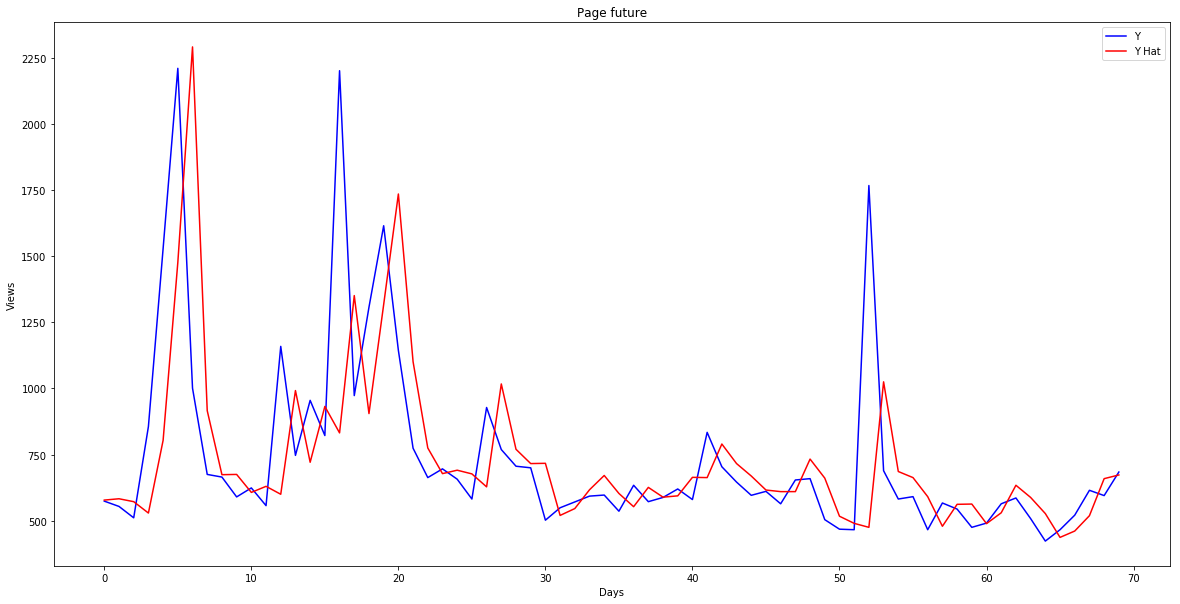

In [135]:
y = page['hits']
yhat = page['prediction']
plot_series(y,"Page future",new_plot=True,plot_show=False,label="Y")
plot_series(yhat,"Page future",new_plot=False,plot_show=True,label="Y Hat", color='red')

/Users/maximelovino/Documents/LOCAL_CODE/WikiForecasting/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/maximelovino/Documents/LOCAL_CODE/WikiForecasting/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/maximelovino/Documents/LOCAL_CODE/WikiForecasting/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


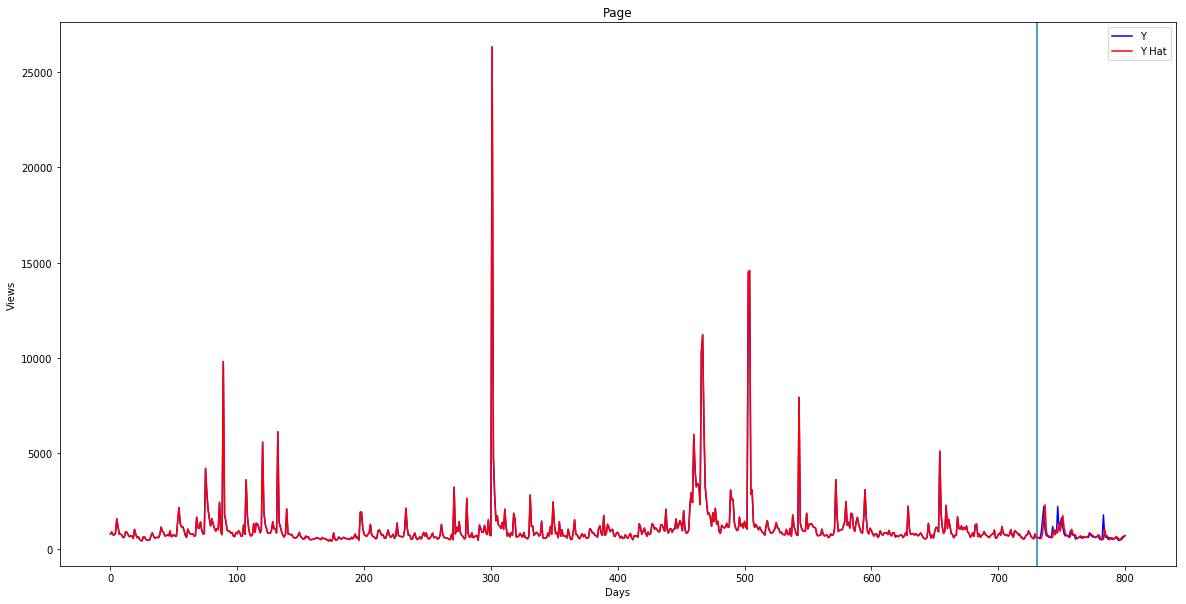

In [142]:
past = train[train['name'] == 33809.0][train['lang'] == 4.0][train['access'] == 0.0][train['agent'] == 0.0]
past = past['hits']
y_full = past.append(y)
yhat_full = past.append(yhat)
plot_series(y_full,"Page",new_plot=True,plot_show=False,label="Y")
plt.axvline(len(past))
plot_series(yhat_full,"Page",new_plot=False,plot_show=True,label="Y Hat", color='red')

In [138]:
mdl.feature_importances_

array([10255,  3113,  1437,  1009,  2762,     0,   677,     0,   138,
        5537,  5072])

In [141]:
train.drop(columns=['hits','date']).columns

Index(['name', 'lang', 'access', 'agent', 'day_of_week', 'month',
       'day_of_year', 'quarter', 'week_of_year', 'last_hits', 'last_diff'],
      dtype='object')